In [ ]:
import kagglehub
fedesoriano_traffic_prediction_dataset_path = kagglehub.dataset_download('fedesoriano/traffic-prediction-dataset')

print('import complete.')

100%|██████████| 277k/277k [00:00<00:00, 38.7MB/s]

Extracting files...
import complete.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from sklearn.metrics import mean_absolute_error

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
import os

   # Print the path where kagglehub downloaded the dataset
print(fedesoriano_traffic_prediction_dataset_path)

for filename in os.listdir(fedesoriano_traffic_prediction_dataset_path):
       print(filename)

data=pd.read_csv(os.path.join(fedesoriano_traffic_prediction_dataset_path, 'traffic.csv'))
data

/root/.cache/kagglehub/datasets/fedesoriano/traffic-prediction-dataset/versions/1
traffic.csv


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [ ]:
data['DateTime']=pd.to_datetime(data['DateTime'])

data["Year"]=data['DateTime'].dt.year

data["Month"]=data['DateTime'].dt.month

data["Date_no"]=data['DateTime'].dt.day

data["Hour"]=data['DateTime'].dt.hour

data["Day"]= data['DateTime'].dt.strftime("%A")
data

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


# **DATA VISUALIZATION**

## **Traffic volume distribution visualised (to understand outliers)**

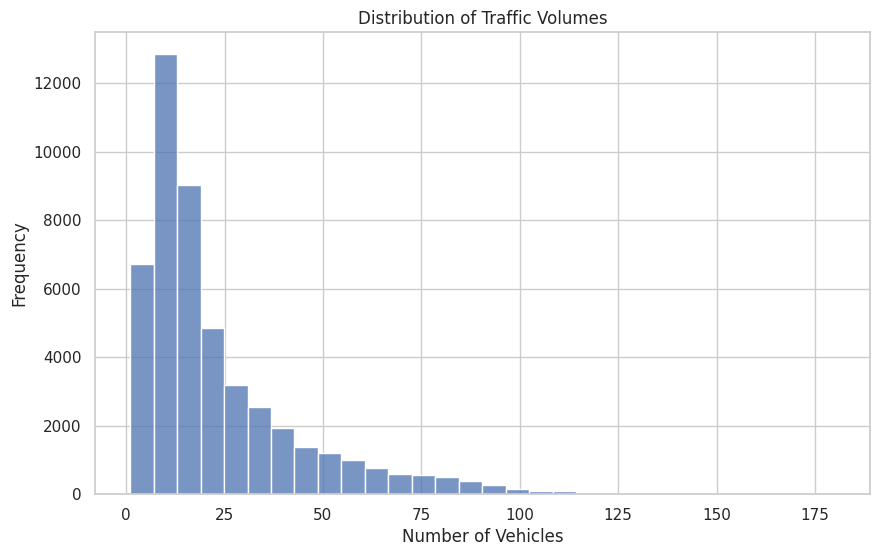

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data['Vehicles'], kde=False, bins=30)
plt.title('Distribution of Traffic Volumes')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.show()

## N.O of vehicles vs date(0 to 30 days)

<Axes: xlabel='Date_no', ylabel='Vehicles'>

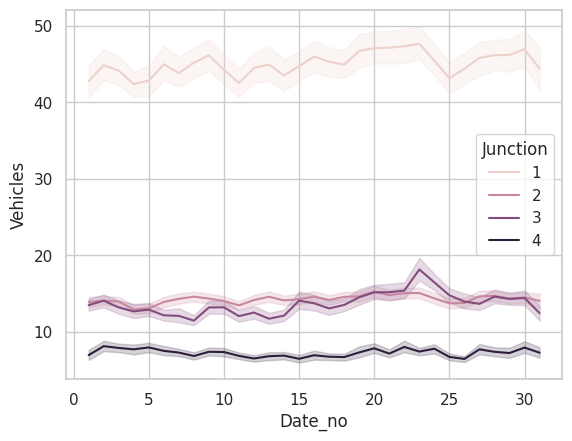

In [ ]:
sns.lineplot(x=data['Date_no'],y="Vehicles",data=data,hue='Junction')


<Axes: xlabel='Date_no', ylabel='Vehicles'>

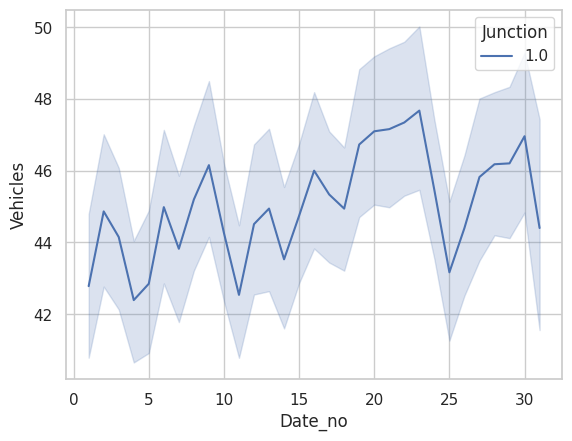

In [ ]:
#for clear visualisation of just juction 1

sns.lineplot(x=data['Date_no'],y="Vehicles",data=data[(data['Junction']==1)],hue='Junction')


##using boxplots to identify outliers

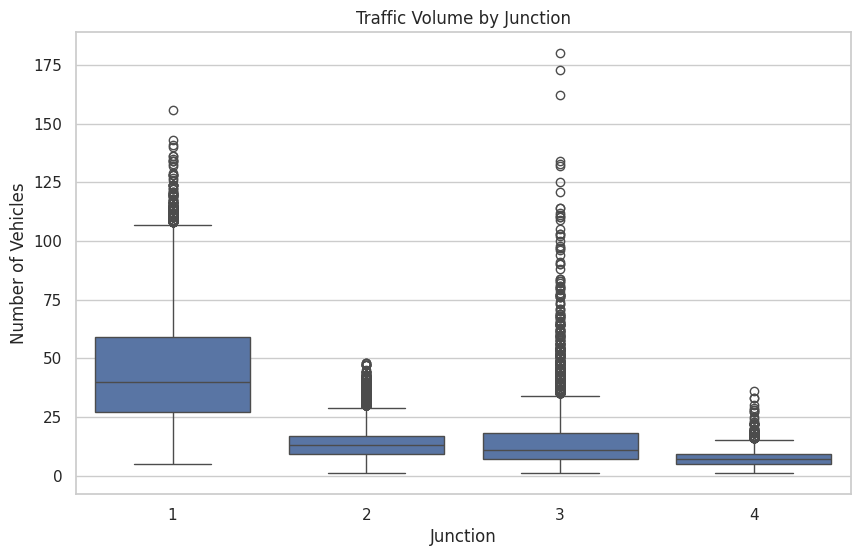

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=data)
plt.title('Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()

## understanding trends during the day (24 hour period)

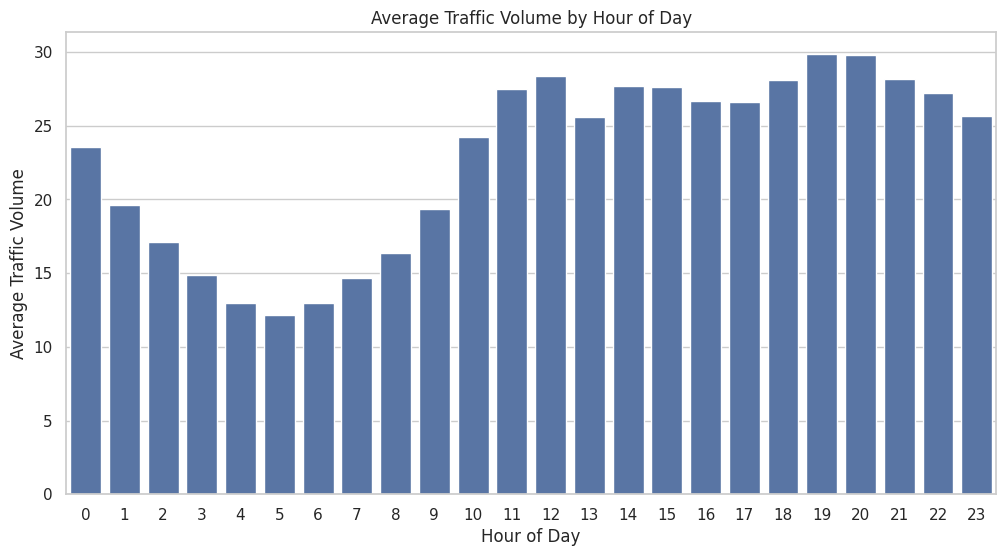

In [ ]:
hourly_traffic = data.groupby('Hour')['Vehicles'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='Vehicles', data=hourly_traffic)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks(np.arange(0, 24, 1))
plt.show()

## understanding trends during the week(7 days)

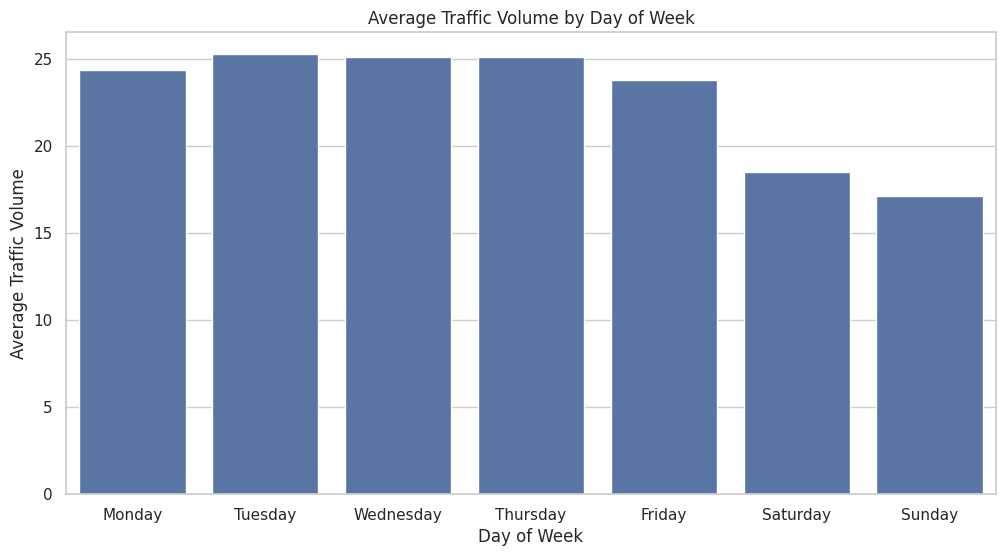

In [ ]:
weekly_traffic = data.groupby('Day')['Vehicles'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Day', y='Vehicles', data=weekly_traffic)
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.show()

## understanding trends in a year (12 months)

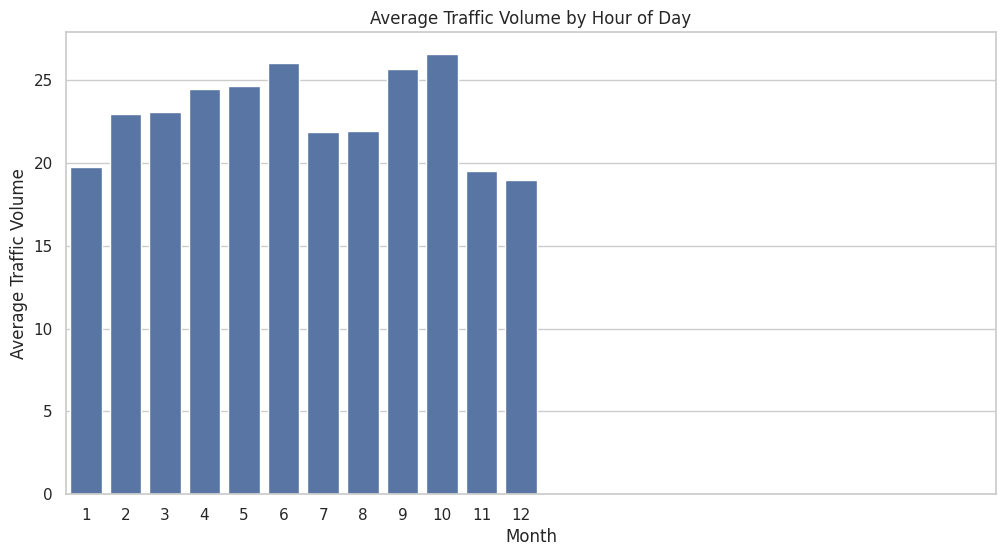

In [ ]:
monthly_traffic = data.groupby('Month')['Vehicles'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Vehicles', data=monthly_traffic)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Month')
plt.ylabel('Average Traffic Volume')
plt.xticks(np.arange(0, 24, 1))
plt.show()

## average traffic volume distribution with junction
### this is to understand how to split data

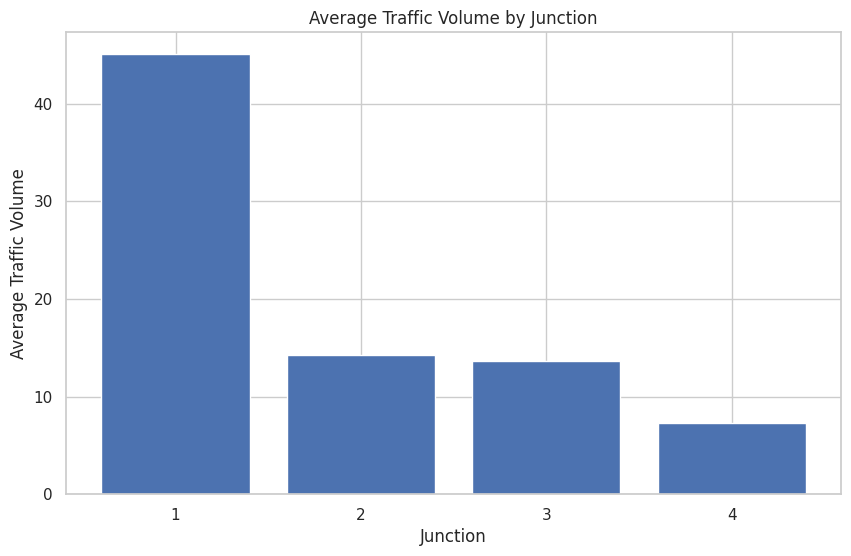

In [ ]:
junction_data = data.groupby('Junction')['Vehicles'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(junction_data['Junction'], junction_data['Vehicles'])
plt.title('Average Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Average Traffic Volume')
plt.xticks(junction_data['Junction'])
plt.show()

# **DATA PRE PROCESSING**

In [ ]:
data['Day'] = pd.to_datetime(data['DateTime']).dt.dayofweek
### above is to convert days into 0-6 format

In [ ]:
data.isna().sum()  ##just in case checking known already that there are no nan values

,0
DateTime,0
Junction,0
Vehicles,0
ID,0
Year,0
Month,0
Date_no,0
Hour,0
Day,0


In [ ]:
data.describe()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
count,48120,48120.000000,48120.000000,4.812000e+04,48120.000000,48120.000000,48120.000000,48120.000000,48120.000000
mean,2016-09-19 06:03:56.109725696,2.180549,22.791334,2.016330e+10,2016.269825,5.884289,15.700748,11.500000,2.996010
min,2015-11-01 00:00:00,1.000000,1.000000,2.015110e+10,2015.000000,1.000000,1.000000,0.000000,0.000000
25%,2016-04-16 01:45:00,1.000000,9.000000,2.016042e+10,2016.000000,3.000000,8.000000,5.750000,1.000000
50%,2016-09-30 03:30:00,2.000000,15.000000,2.016093e+10,2016.000000,5.000000,16.000000,11.500000,3.000000
75%,2017-02-25 16:00:00,3.000000,29.000000,2.017023e+10,2017.000000,9.000000,23.000000,17.250000,5.000000
max,2017-06-30 23:00:00,4.000000,180.000000,2.017063e+10,2017.000000,12.000000,31.000000,23.000000,6.000000
std,NaN,0.966955,20.750063,5.944854e+06,0.616093,3.569872,8.784073,6.922258,2.000017


In [ ]:
data.dtypes

,0
DateTime,datetime64[ns]
Junction,int64
Vehicles,int64
ID,int64
Year,int32
Month,int32
Date_no,int32
Hour,int32
Day,int32


## DATA normalisation using standard z-score normalisation
### actually not necessary but can be useful

you can bring actual prediction back using
 real prediction = pred*std + av
 to get back a real prediction with model after applying

In [ ]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev



dat, av, std = Normalize(data, 'Vehicles')
dat

,Vehicles
0,-0.375485
1,-0.471870
2,-0.616448
3,-0.761026
4,-0.664641
...,...
48115,-0.568255
48116,0.347405
48117,-0.327292
48118,-0.038136


# DATA CORRELATION

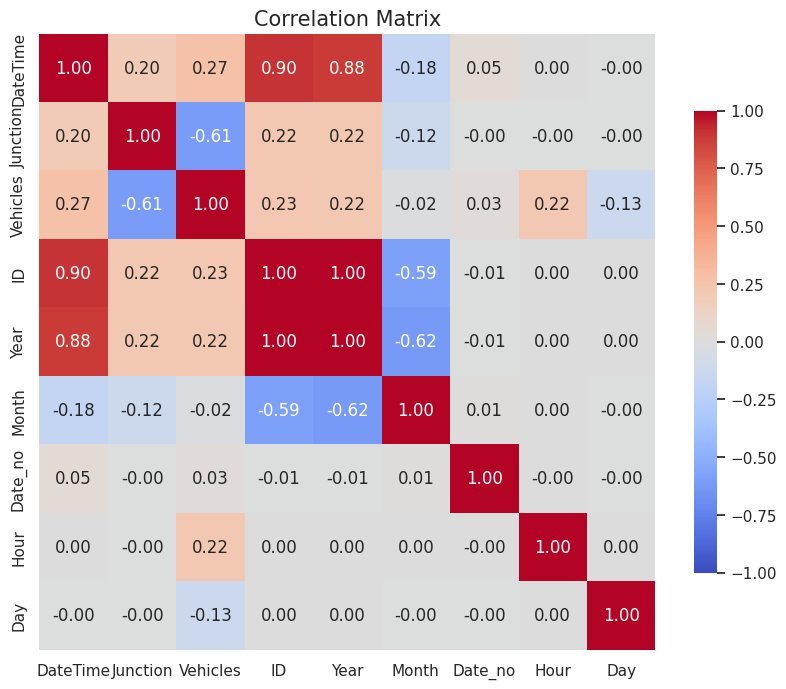

In [ ]:

correlation_matrix = data.corr()

# Set up the plot size
plt.figure(figsize=(10, 8))

# Use seaborn to create a heatmap
sns.heatmap(correlation_matrix,annot=True,fmt=".2f", cmap="coolwarm",vmin=-1, vmax=1,square=True,cbar_kws={"shrink": 0.75})

# Add titles and labels
plt.title("Correlation Matrix", fontsize=15)
plt.show()


In [ ]:
def Difference(df,col, interval):
    dif = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        dif.append(value)
    return dif

dat, av, std = Normalize(data, "Vehicles")
Diff = Difference(dat, col="Vehicles", interval=(24*7)) #taking a week's diffrence
div = dat[24*7:]
div["Diff"]= Diff
dif = div["Diff"].dropna() # after calculation remaining rows will get nan values
dif = dif.to_frame()
dif.head()

<ipython-input-20-dcd939b97c76>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  div["Diff"]= Diff


,Diff
168,-0.096385
169,0.144578
170,0.048193
171,0.048193
172,0.048193


# final data visualisation

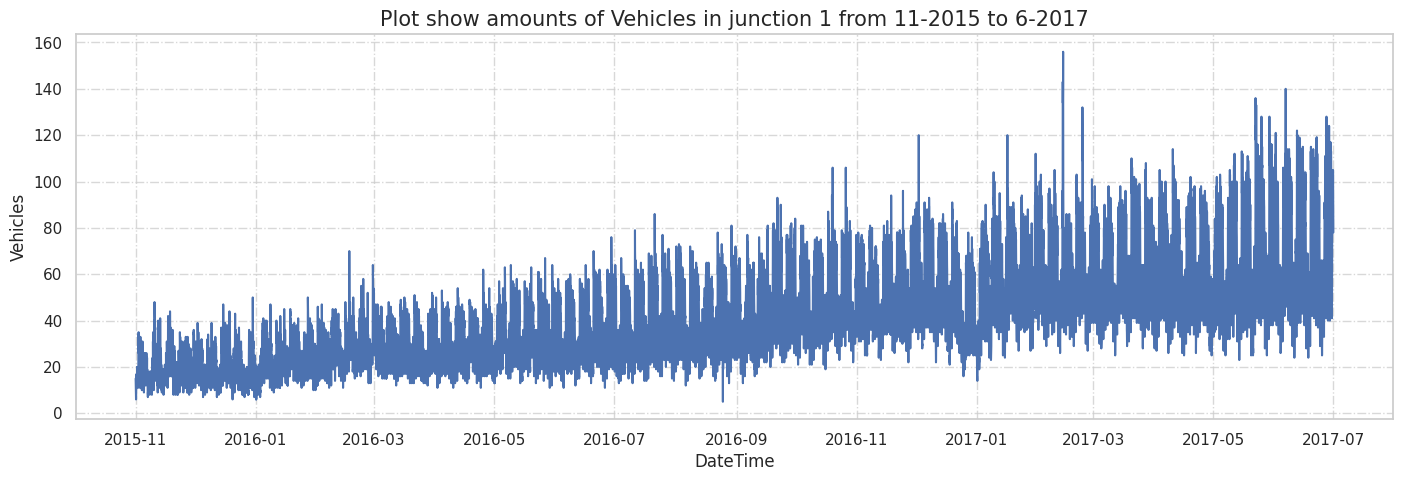

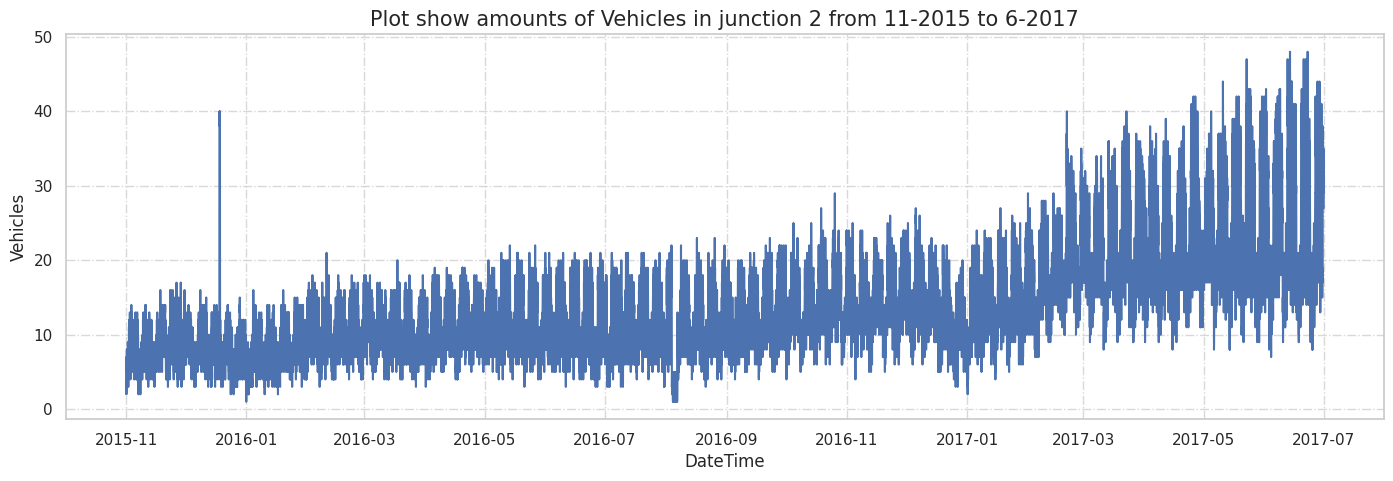

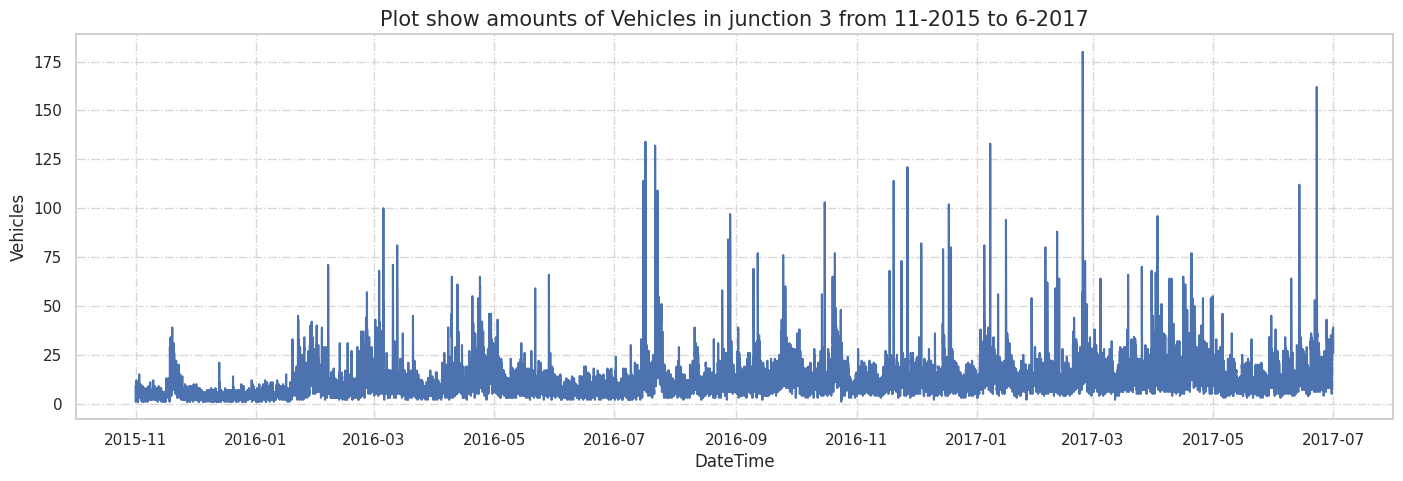

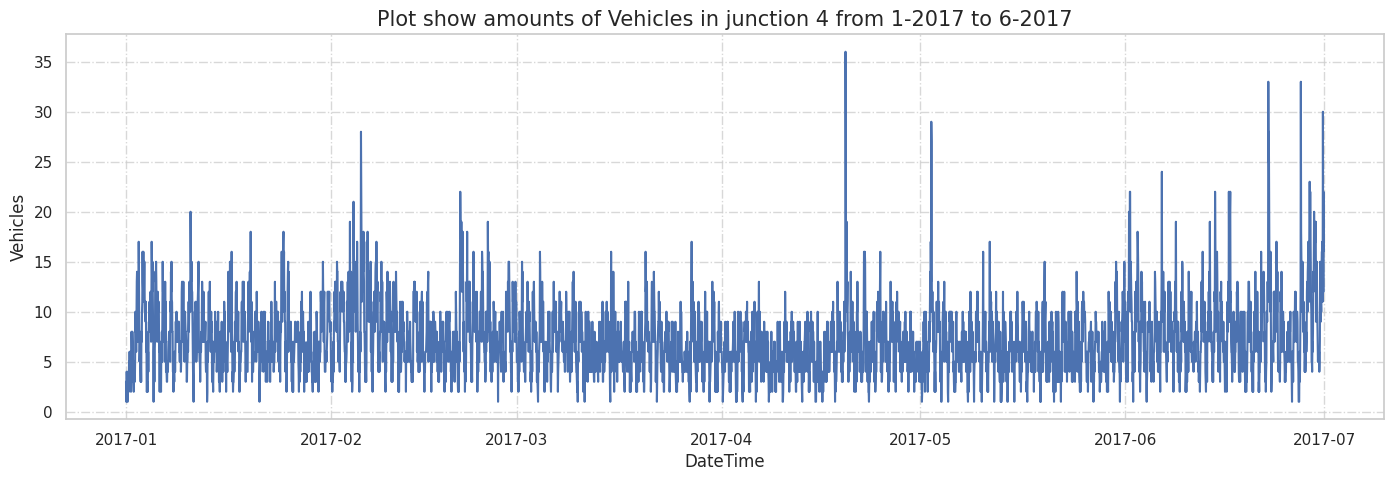

In [ ]:
def make_time_plot(junction=1):
    f, ax = plt.subplots(figsize=(17, 5))
    df=data[data.Junction == junction]
    ax = sns.lineplot(data=df, y='Vehicles', x='DateTime', ax=ax)
    start = df.head(1)
    end = df.tail(1)
    ax.set_title(f'Plot show amounts of Vehicles in junction {junction} from {start.Month.iloc[0]}-{start.Year.iloc[0]} to {end.Month.iloc[0]}-{end.Year.iloc[0]}', fontsize=15)
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

for i in range(1,5):
    make_time_plot(i)

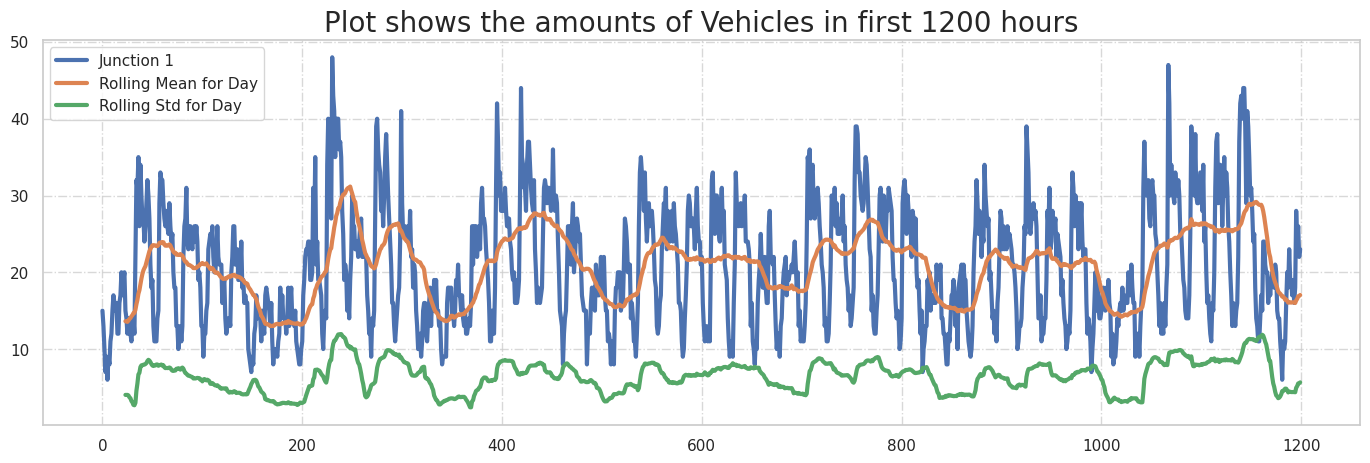

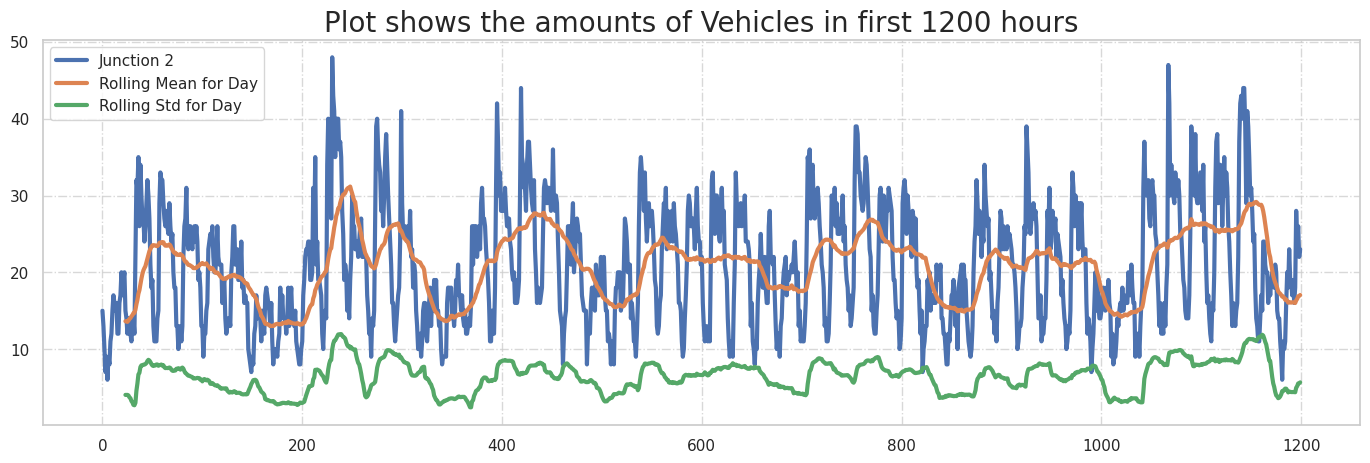

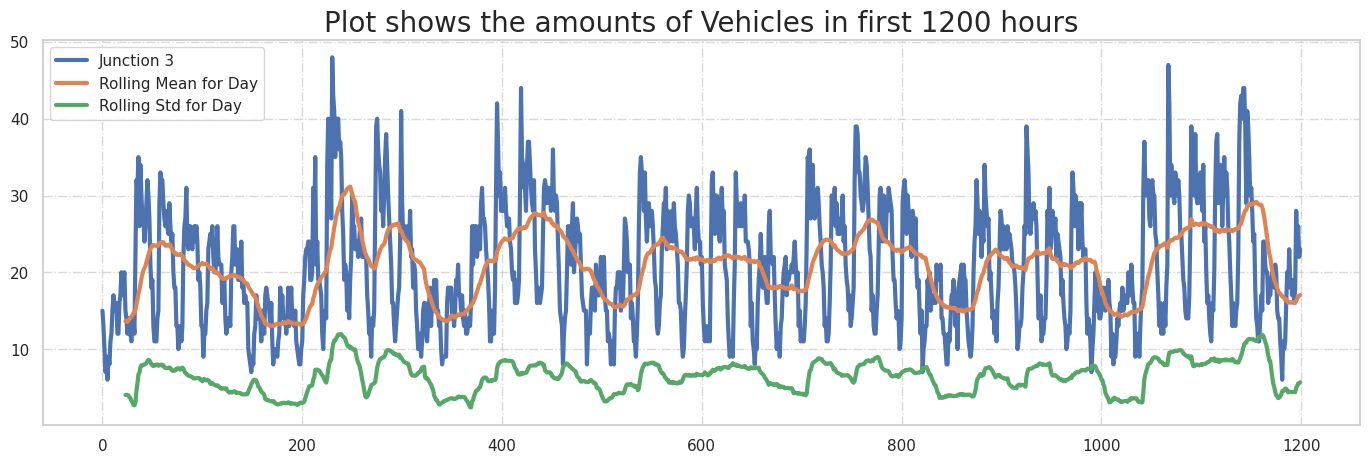

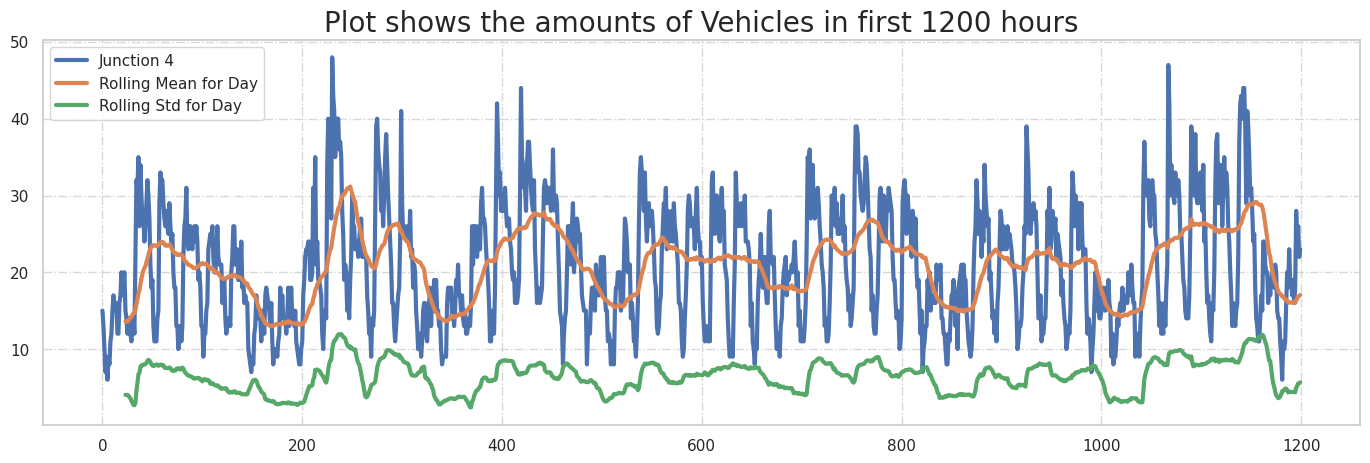

In [ ]:
def plo(i=1):
  f, ax = plt.subplots(figsize=(17, 5))
  foo = data.iloc[:1200]
  foo.Vehicles.plot(lw=3)
  foo.Vehicles.rolling(24).mean().plot(lw=3)
  foo.Vehicles.rolling(24).std().plot(lw=3)
  plt.legend([f'Junction {i}', 'Rolling Mean for Day', 'Rolling Std for Day'])
  plt.grid(True, alpha=0.75, ls='-.')
  plt.title('Plot shows the amounts of Vehicles in first 1200 hours', fontsize=20)
  plt.show()
for i in range(1,5):
  plo(i)

###normalised vehicle data view

In [ ]:
dat.shape
dat

,Vehicles
0,-0.375485
1,-0.471870
2,-0.616448
3,-0.761026
4,-0.664641
...,...
48115,-0.568255
48116,0.347405
48117,-0.327292
48118,-0.038136


# TRAIN TEST SPLITING

In [ ]:
dat

,Vehicles
0,-0.375485
1,-0.471870
2,-0.616448
3,-0.761026
4,-0.664641
...,...
48115,-0.568255
48116,0.347405
48117,-0.327292
48118,-0.038136


##perfect splitting junction wise such thatm each junction split 70/30

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(data[['Month','Date_no','Hour','Day','Junction']])
y = scaler_y.fit_transform(data[['Vehicles']])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)



X_train.shape,X_test.shape,y_train.shape,y_test.shape

((43308, 5), (4812, 5), (43308, 1), (4812, 1))

#**LINEAR REGRESSION MODEL**

###LR MODEL TRAINING

In [ ]:
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train, y_train)
y_pred = model_LinearRegression.predict(X_test)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.006963923199092213


###TOY LR MODEL EXAMPLE

In [ ]:
month = 10
date_no = 31
hour = 23
day = 6
jun= 3
new_data = pd.DataFrame({'Month': [month], 'Date_no': [date_no], 'Hour': [hour], 'Day': [day],'Junction':[jun]})

# Scale the new data using the same scaler used for training
new_data_scaled = scaler_X.transform(new_data[['Month', 'Date_no', 'Hour', 'Day','Junction']])

# Predict using the model for Junction 1 (models[0])
prediction_sc = model_LinearRegression.predict(new_data_scaled)
prediction = scaler_y.inverse_transform(prediction_sc)
prediction

array([[13.95603091]])

#MLP MODEL

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0189 - val_loss: 0.0072
Epoch 2/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0096 - val_loss: 0.0062
Epoch 3/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 4/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 5/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 6/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 7/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 8/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0064 - val_loss: 0.0050
Epoch 9/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 10/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 11/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 12/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms

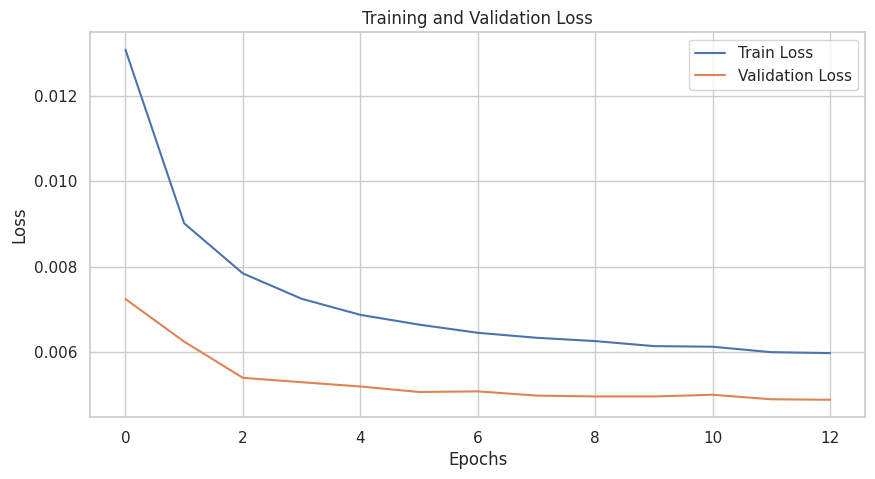

In [ ]:


class MLPModel:
  def __init__(self, input_dim, initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9,string='relu'):
        # Initialize the MLP model parameters
    self.input_dim = input_dim
    self.initial_learning_rate = initial_learning_rate
    self.decay_steps = decay_steps
    self.decay_rate = decay_rate
    self.string = string
    self.model = self.build_model()
    self.history = {}  # To keep track of training and validation loss
    self.compile_model()

  def compile_model(self):
        # Compile the model with SGD optimizer and mean squared error loss
    self.model.compile(optimizer=SGD(learning_rate=self.initial_learning_rate, momentum=0.9),loss='mean_squared_error')

  def build_model(self):
        # Build the MLP model architecture
    model = Sequential()
    model.add(Dense(150, activation=self.string, input_dim=self.input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

  def fit(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=120):
        # Prepare data by removing unnecessary dimension
    X_train = np.squeeze(X_train)
    X_test = np.squeeze(X_test)

        # Set up early stopping
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

        # Fit the model and saving of the history
    history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,batch_size=batch_size, callbacks=[early_stopping])

        # Store the training and validation loss for graph ploting
    self.history['train_loss'] = history.history['loss']
    self.history['val_loss'] = history.history['val_loss']

  def predict(self, X):
      #predictio
    X = np.squeeze(X)  # just in case
    return self.model.predict(X)

  def error(self, X_test, y_test):
    y_pred = self.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

  def plot_loss(self):
        # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(self.history['train_loss'], label='Train Loss')
    plt.plot(self.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


input_dimension = X_train.shape[1]  # Number of features in the input data
string = 'relu'
mlp_model = MLPModel(input_dim=input_dimension,string=string)

# Training
mlp_model.fit(X_train, y_train, X_test, y_test, epochs=50, batch_size=120)

# testing
predictions_original = mlp_model.predict(X_test)

#
mae = mlp_model.error(X_test, y_test)
print("Mean Absolute Error on test data:", mae)

# Plot training and validation loss
mlp_model.plot_loss()


##PLAY GROUND FOR MLP-ACTIVATION FUNCTION (1ST only)

enter the activation function: sigmoid
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0356 - val_loss: 0.0126
Epoch 2/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0141 - val_loss: 0.0126
Epoch 3/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 4/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 5/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0138 - val_loss: 0.0126
Epoch 6/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 7/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 8/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 9/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 10/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0138 - val_loss: 0.0126
Epoch 11/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0138 - val_loss: 0.0126
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━

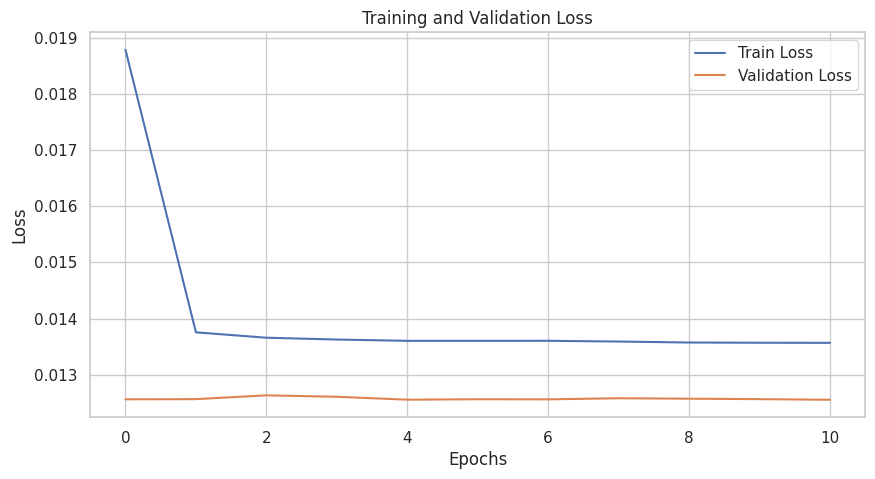

In [ ]:
string = input("enter the activation function: ")
input_dim=X_train.shape[1]
model_mlp_custom = MLPModel(input_dim=input_dimension,string=string)

#train
model_mlp_custom.fit(X_train, y_train, X_test, y_test, epochs=50, batch_size=120)
#test
predictions_custom = model_mlp_custom.predict(X_test)
#error
mae_custom = model_mlp_custom.error(X_test, y_test)
#showing error and loss_plot
print("\n","Mean Absolute Error on test data:", mae_custom,"\n")
model_mlp_custom.plot_loss()

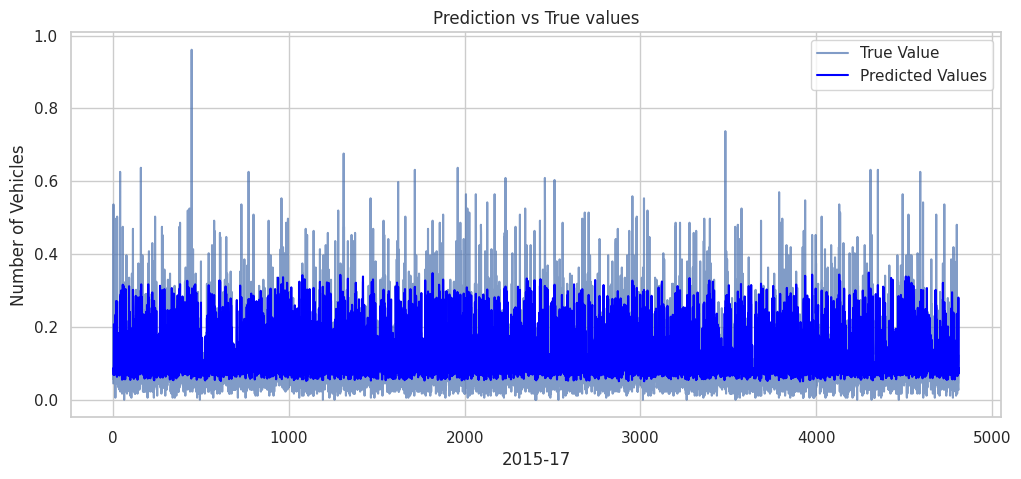

In [ ]:
def PredictionsPlot(test, predicted, m):
    plt.figure(figsize=(12, 5))
    plt.plot(test, label="True Value", alpha=0.7)
    plt.plot(predicted, color='blue', label="Predicted Values")
    plt.title("Prediction vs True values")
    plt.xlabel("2015-17")
    plt.ylabel("Number of Vehicles")
    plt.legend()

    plt.legend()
    plt.show()

PredictionsPlot(y_test, predictions_original, 0)

#ACTUAL MODEL USE (BY PREDICTION OF GIVEN MODELS)

##LR MODEL

In [ ]:

month = int(input("ENTER THE MONTH: "))
date_no = int(input("ENTER THE DATE IN THAT MONTH: "))
hour = int(input("ENTER THE HOUR: "))
day = int(input("ENTER THE DAY OF WEEK: "))

prediction_LR = []
for i in range(0,4):
  LR_dat= pd.DataFrame({'Month': [month], 'Date_no': [date_no], 'Hour': [hour], 'Day': [day],'Junction' : [i]})
  LR_dat = scaler_X.transform(LR_dat[['Month', 'Date_no', 'Hour', 'Day','Junction']])
  prediction= model_LinearRegression.predict(LR_dat)

  prediction_LR.append(prediction[0][0])
prediction_LR = np.array(prediction_LR).reshape(1, -1)
prediction_LR= scaler_y.inverse_transform(np.array(prediction_LR))
prediction_LR

ENTER THE MONTH: 12
ENTER THE DATE IN THAT MONTH: 3
ENTER THE HOUR: 3
ENTER THE DAY OF WEEK: 2


array([[43.49201129, 30.01677088, 16.54153047,  3.06629006]])

##MLP model

In [ ]:
pre_test=np.array([])
for i in range (0,4):
  MLP_dat= pd.DataFrame({'Month': [month], 'Date_no': [date_no], 'Hour': [hour], 'Day': [day],'Junction' : [i]})

  MLP_dat = scaler_X.transform(MLP_dat[['Month', 'Date_no', 'Hour', 'Day','Junction']])
  pre_test=np.append(pre_test,MLP_dat.flatten())

prediction_MLP = mlp_model.predict(pre_test.reshape(4,5))
prediction_MLP = scaler_y.inverse_transform(prediction_MLP)
prediction_MLP

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[52.66],
       [21.7 ],
       [14.75],
       [13.03]], dtype=float16)

# FINDING SHORTEST PATH

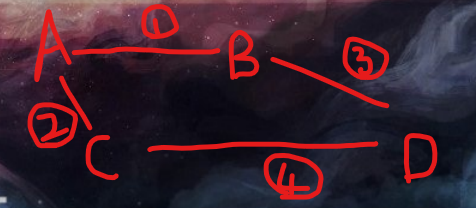

IF YOU USE THE ABOVE PATHS FOR REFERENCE TO UNDERSTAND TRAFFIC AND SHORTEST PATHS AND JUNCTIONS ARE NUMBERED AS 1,2,3,4
A TO D ie either 1+3 or 2+4 which is shortest is the shortest path

In [ ]:
from abc import abstractmethod
def shortestpath(pred):

  p = pred[0, 0] + pred[2, 0]
  q = pred[1, 0] + pred[3, 0]
  if p < q:
    return 'ABD'
  else:-+
    return 'ACD'

print("for LR model it is: ", shortestpath(prediction_LR.reshape(4, 1)))
print("for MLP model it is: ",shortestpath(prediction_MLP.reshape(4, 1)))

for LR model it is:  ACD
for MLP model it is:  ACD
